# ** Import Libraries **

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import accuracy_score, confusion_matrix
import os
from pathlib import Path
from tqdm.auto import tqdm
import random
from typing import Dict,List
import warnings
warnings.filterwarnings("ignore")

c:\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ** Load Data and EDA **

In [2]:
# Tổng số hình ảnh
IMAGE_PATH = Path("D:/garbage_classification/")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg"))

print(f"Tổng số hình ảnh = {len(IMAGE_PATH_LIST)}")

Tổng số hình ảnh = 10163


In [3]:
# Tổng số hình ảnh cho mỗi lớp
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 30)
print(" " * 17, "Tổng số hình ảnh cho mỗi lớp")
print("**" * 30)
for c in classes:
    imgs_class = len(list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg")))
    print(f"* {c} => {imgs_class} images")

************************************************************
                  Tổng số hình ảnh cho mỗi lớp
************************************************************
* battery => 945 images
* biological => 985 images
* brown-glass => 607 images
* cardboard => 891 images
* clothes => 1000 images
* green-glass => 629 images
* metal => 769 images
* paper => 1000 images
* plastic => 865 images
* shoes => 1000 images
* trash => 697 images
* white-glass => 775 images


In [4]:
for c in classes:
    class_path = os.path.join(IMAGE_PATH, c)
    image_list = list(Path(class_path).glob("*.jpg"))
    
    # Số lượng hình ảnh cần giữ lại trong mỗi lớp
    keep_images = 1000
    
    # Xóa bớt hình ảnh nếu số lượng vượt quá giới hạn
    if len(image_list) > keep_images:
        images_to_delete = len(image_list) - keep_images
        images_to_delete = min(images_to_delete, len(image_list))  # Đảm bảo không xóa quá số lượng hình ảnh hiện có
        
        for i in range(images_to_delete):
            os.remove(image_list[i])


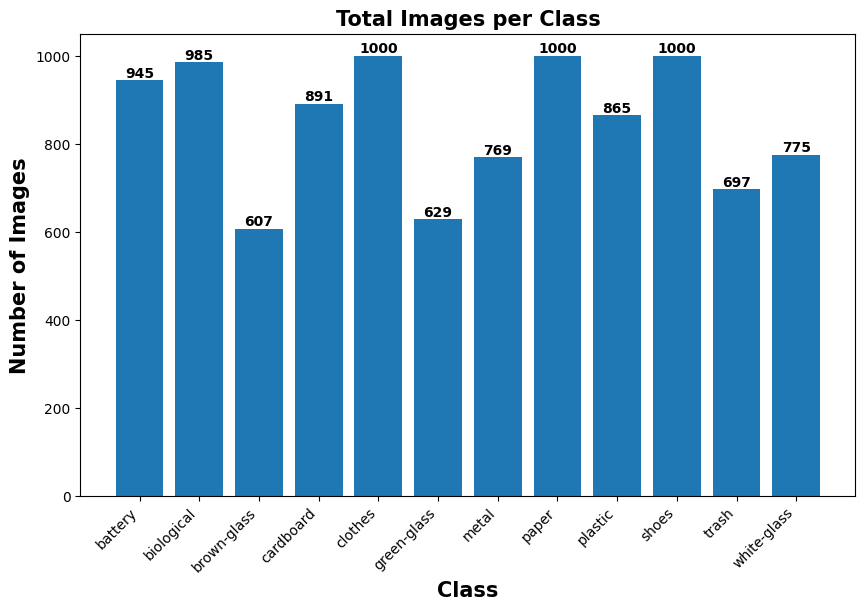

In [5]:
# Tạo danh sách rỗng để lưu tên lớp và số lượng hình ảnh
class_names = []
image_counts = []

# Lặp qua từng lớp
for c in classes:
    class_dir = os.path.join(IMAGE_PATH, c)
    image_files = list(Path(class_dir).glob("*.jpg"))
    
    # Thêm tên lớp và số lượng hình ảnh vào danh sách
    class_names.append(c)
    image_counts.append(len(image_files))

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts)
plt.xlabel('Class', fontweight='bold',size='15')
plt.ylabel('Number of Images', fontweight='bold',size='15')
plt.title('Total Images per Class', fontweight='bold',size='15')

# Hiển thị số lượng trên mỗi cột
for i, count in enumerate(image_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', rotation=0, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

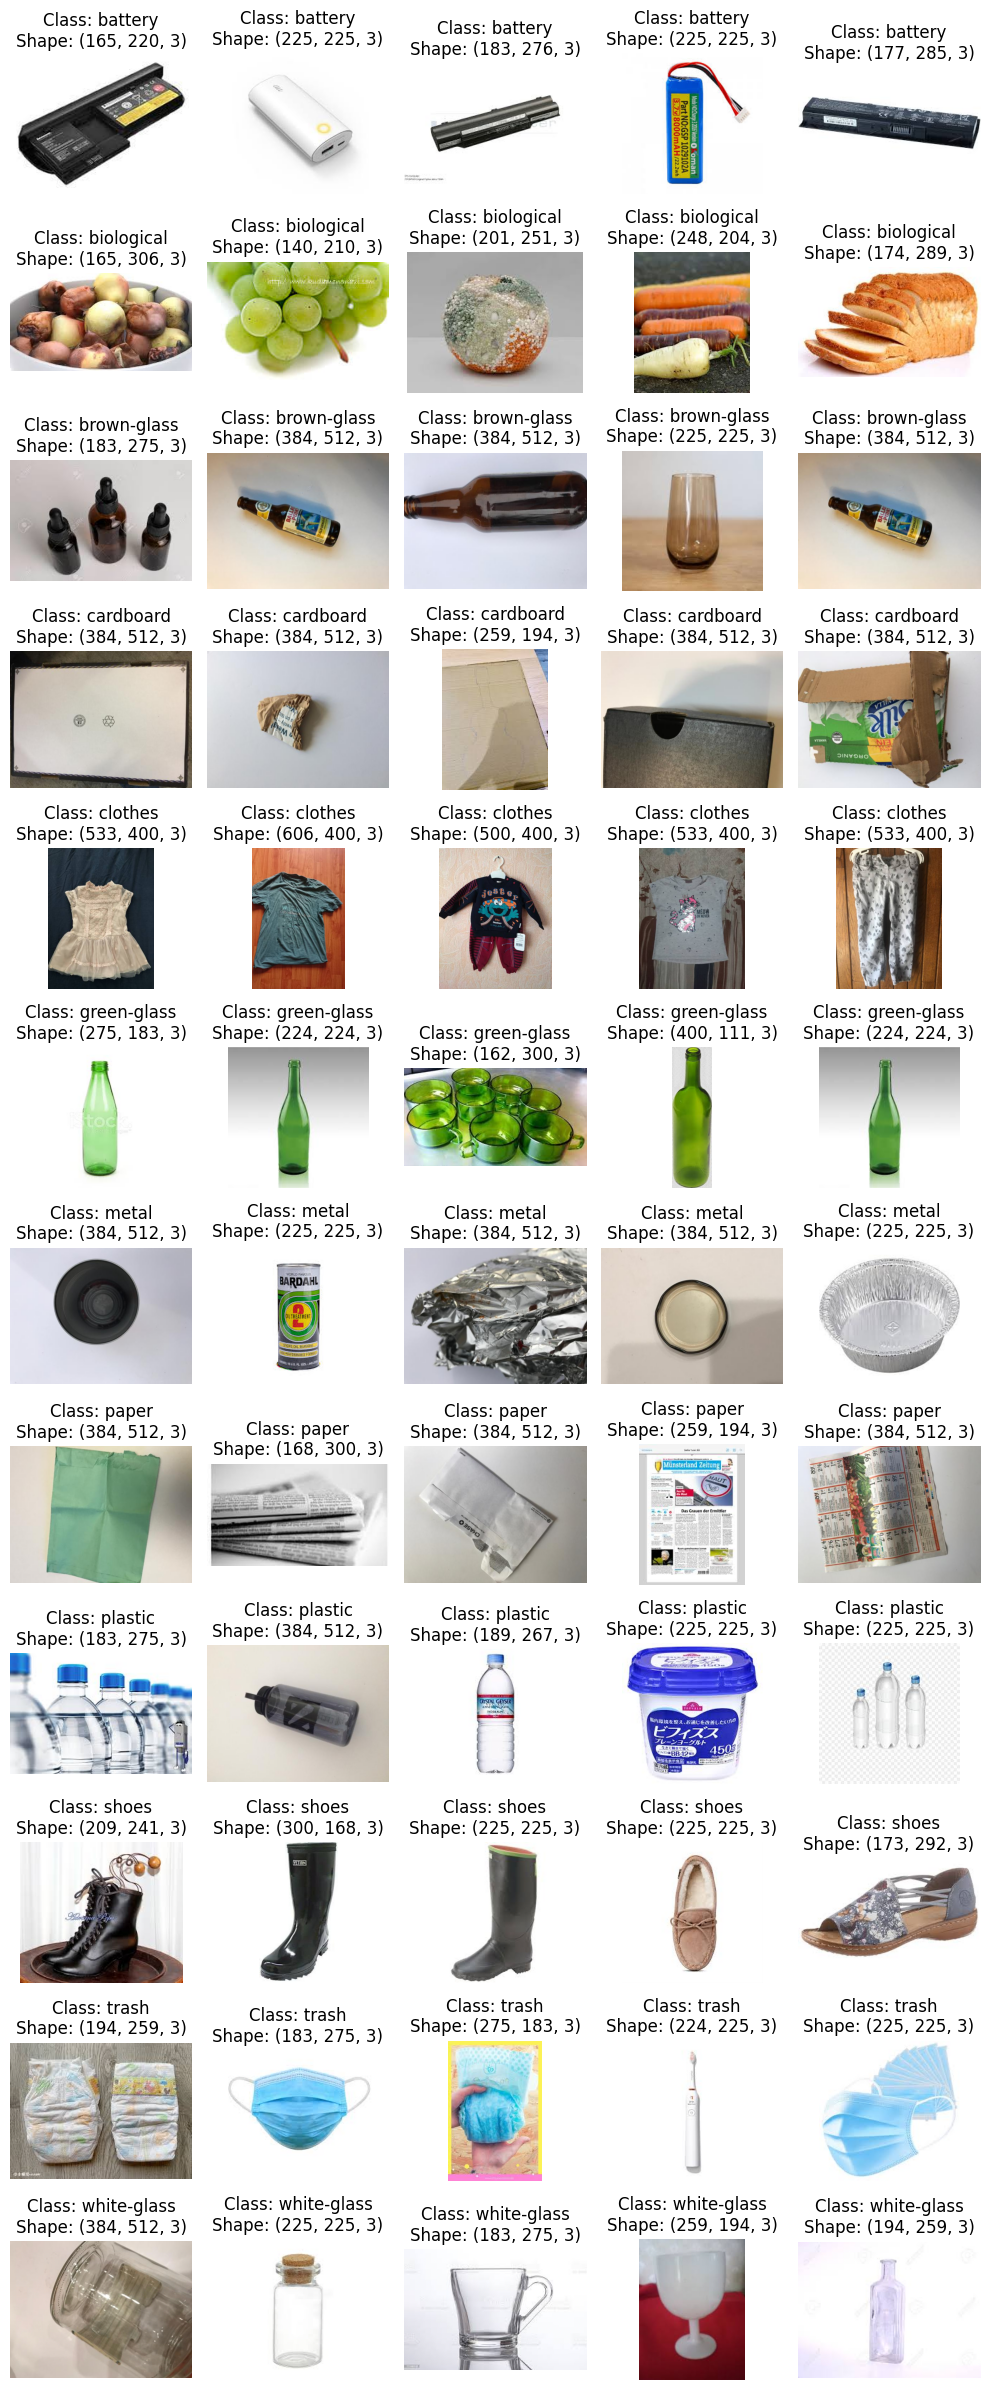

In [6]:
# Số lượng hình ảnh muốn hiển thị từ mỗi lớp
NUM_IMAGES = 5

fig, ax = plt.subplots(nrows = len(classes), 
                       ncols = NUM_IMAGES, 
                       figsize = (10, 24))

p = 0
# Lặp qua từng lớp
for c in classes:
    imgs_total = list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg"))
    
    # Chọn ngẫu nhiên một số hình ảnh từ mỗi lớp
    imgs_selected = random.choices(imgs_total, k = NUM_IMAGES)
    
    for i,img_select in enumerate(imgs_selected):
        img_bgr = cv2.imread(str(img_select))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
        ax[p,i].axis("off")
        
    p += 1
    
fig.tight_layout()
fig.show()

Tạo danh sách rỗng để lưu trữ đường dẫn và label của hình ảnh

In [7]:
# Tạo danh sách rỗng để lưu trữ đường dẫn và nhãn của hình ảnh
image_paths = []
labels = []
filenames = []

# Lặp qua từng lớp
for c in classes:
    class_dir = os.path.join(IMAGE_PATH, c)
    image_files = os.listdir(class_dir)
    
    # Lặp qua từng tệp hình ảnh trong thư mục lớp
    for image_file in image_files:
        # Lấy đường dẫn đầy đủ của hình ảnh
        image_path = os.path.join(class_dir, image_file)
        image_paths.append(image_path)
        labels.append(c)
        filenames.append(image_file)

# Tạo dataframe từ danh sách
data = pd.DataFrame({'image_path': image_paths, 'label': labels, 'filename': filenames})
data


,image_path,label,filename
0,D:\garbage_classification\battery\battery1.jpg,battery,battery1.jpg
1,D:\garbage_classification\battery\battery10.jpg,battery,battery10.jpg
2,D:\garbage_classification\battery\battery100.jpg,battery,battery100.jpg
3,D:\garbage_classification\battery\battery101.jpg,battery,battery101.jpg
4,D:\garbage_classification\battery\battery102.jpg,battery,battery102.jpg
...,...,...,...
10158,D:\garbage_classification\white-glass\white-gl...,white-glass,white-glass95.jpg
10159,D:\garbage_classification\white-glass\white-gl...,white-glass,white-glass96.jpg
10160,D:\garbage_classification\white-glass\white-gl...,white-glass,white-glass97.jpg
10161,D:\garbage_classification\white-glass\white-gl...,white-glass,white-glass98.jpg


# Model

In [8]:
# Shape of EfficientNetB0
im_shape = (180, 180)
batch_size = 32
SEED = 123

### Image Augmentation

**Image augmentation** is a technique of applying different transformations to original images which results in multiple transformed copies of the same image. These image augmentation techniques not only expand the size of your dataset but also incorporate a level of variation in the dataset which allows your model to generalize better on unseen data. Keras **ImageDataGenerator** class provides a quick and easy way to augment the images. It provides a host of different augmentation techniques like standardization, rotation, shifts, flips, brightness change, and many more. It is designed to provide real-time data augmentation. Meaning it is generating augmented images on the fly while your model is still in the training stage. ImageDataGenerator class ensures that the model receives new variations of the images at each epoch.

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

In [10]:
path = [None] * len(IMAGE_PATH_LIST)
label = [None] * len(IMAGE_PATH_LIST)

for i,img_path in enumerate(IMAGE_PATH_LIST):
    path[i] = img_path
    label[i] = img_path.parent.stem
    
df_path_label = pd.DataFrame({"path":path, 
                              "label":label})

df_path_label.head()

df_train, df_valid = train_test_split(df_path_label, 
                                     test_size = 0.3, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_path_label["label"])

df_valid, df_test = train_test_split(df_valid, 
                                     test_size = 0.5, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_valid["label"])

#label_map = dict(zip(classes, range(0, len(classes))))

#df_train["label"] = df_train["label"].map(label_map)
#df_valid["label"] = df_valid["label"].map(label_map)
#df_test["label"] = df_test["label"].map(label_map)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

len(df_train), len(df_valid), len(df_test)

(7114, 1524, 1525)

In [11]:
Counter(df_train["label"])

Counter({'paper': 700,
         'green-glass': 440,
         'clothes': 700,
         'trash': 488,
         'biological': 689,
         'battery': 661,
         'metal': 538,
         'shoes': 700,
         'cardboard': 624,
         'brown-glass': 425,
         'plastic': 606,
         'white-glass': 543})

In [12]:
Counter(df_valid["label"])

Counter({'paper': 150,
         'clothes': 150,
         'battery': 142,
         'brown-glass': 91,
         'green-glass': 95,
         'white-glass': 116,
         'metal': 115,
         'trash': 105,
         'shoes': 150,
         'plastic': 129,
         'biological': 148,
         'cardboard': 133})

In [13]:
Counter(df_test["label"])

Counter({'green-glass': 94,
         'metal': 116,
         'battery': 142,
         'plastic': 130,
         'white-glass': 116,
         'cardboard': 134,
         'shoes': 150,
         'brown-glass': 91,
         'biological': 148,
         'clothes': 150,
         'paper': 150,
         'trash': 104})

Sử dụng ImageDataGenerator trên tập dữ liệu đào tạo, kiểm tra và xác thực.

In [14]:
df_train['path'] = df_train['path'].astype(str)
df_train['label'] = df_train['label'].astype(str)
train_generator = data_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGE_PATH,
    x_col='path',
    y_col='label',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=SEED)

Found 7114 validated image filenames belonging to 12 classes.


In [15]:
df_valid['path'] = df_valid['path'].astype(str)
df_valid['label'] = df_valid['label'].astype(str)
valid_generator = data_generator.flow_from_dataframe(
    dataframe=df_valid,
    directory=IMAGE_PATH,
    x_col='path',
    y_col='label',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=SEED)

Found 1524 validated image filenames belonging to 12 classes.


In [16]:
df_test['path'] = df_test['path'].astype(str)
df_test['label'] = df_test['label'].astype(str)
test_generator = data_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=IMAGE_PATH,
    x_col='path',
    y_col='label',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=SEED)

Found 1525 validated image filenames belonging to 12 classes.


In [17]:
nb_train_samples = train_generator.samples
nb_validation_samples = valid_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


### EfficientNetB0

**Transfer Learning** is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task. To put it simply—a model trained on one task is repurposed on a second, related task as an optimization that allows rapid progress when modeling the second task. By applying transfer learning to a new task, one can achieve significantly higher performance than training with only a small amount of data.

**EfficientNet-B0** is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 180-by-180.

In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
'''
Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
We flatten the output of the convolutional layers to create a single long feature vector. 
And it is connected to the final classification model, which is called a fully-connected layer.
'''
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False

# model.summary()

optimizer = Adam()
'''
Optimizers are Classes or methods used to change the attributes of the model such as weights and learning rate 
in order to reduce the losses. Optimizers help to get results faster.
'''
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

epochs = 10

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='model_EfficientnetB0_10.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=valid_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/10


222/222 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.8678
Epoch 1: val_loss improved from inf to 0.26892, saving model to model_EfficientnetB0_10.h5
222/222 [==============================] - 216s 931ms/step - loss: 0.4333 - accuracy: 0.8678 - val_loss: 0.2689 - val_accuracy: 0.9189
Epoch 2/10
222/222 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9821
Epoch 2: val_loss did not improve from 0.26892
222/222 [==============================] - 149s 673ms/step - loss: 0.0592 - accuracy: 0.9821 - val_loss: 0.2885 - val_accuracy: 0.9282
Epoch 3/10
222/222 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9898
Epoch 3: val_loss improved from 0.26892 to 0.26581, saving model to model_EfficientnetB0_10.h5
222/222 [==============================] - 151s 679ms/step - loss: 0.0277 - accuracy: 0.9898 - val_loss: 0.2658 - val_accuracy: 0.9348
Epoch 4/10
222/222 [==============================] - ETA: 0s - loss: 0.

# Prediction and Accuracy

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

1525/1525 [==============================] - 72s 45ms/step
Classification Report
              precision    recall  f1-score   support

     battery       0.94      0.95      0.95       142
  biological       0.97      0.96      0.97       148
 brown-glass       0.88      0.99      0.93        91
   cardboard       0.88      0.92      0.90       134
     clothes       0.98      0.98      0.98       150
 green-glass       0.88      0.89      0.89        94
       metal       0.88      0.90      0.89       116
       paper       0.94      0.84      0.89       150
     plastic       0.87      0.82      0.85       130
       shoes       0.96      0.99      0.97       150
       trash       0.90      0.88      0.89       104
 white-glass       0.85      0.86      0.85       116

    accuracy                           0.92      1525
   macro avg       0.91      0.92      0.91      1525
weighted avg       0.92      0.92      0.92      1525



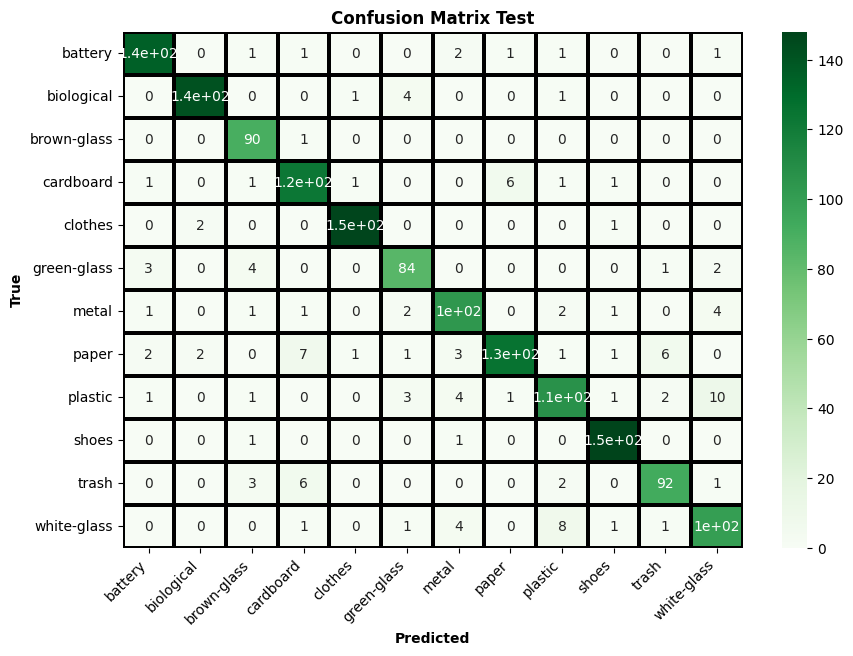

In [32]:
# We visualize the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig,ax = plt.subplots(figsize=(10,6.7))
sns.heatmap(cm, 
            cmap = "Greens", 
            annot = True, 
            linewidths = 1.5,
            linecolor = "black",
            xticklabels = classes, 
            yticklabels = classes,
            ax = ax)

ax.set_title("Confusion Matrix Test", fontsize = 12, fontweight = "bold", color = "black")
ax.set_xlabel("Predicted", fontsize = 10, fontweight = "bold", color = "black")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("True", fontsize = 10, fontweight = "bold", color = "black")
fig.show()

- **Accuracy**

In [33]:
print(f"Accuracy: {accuracy_score(test_generator.classes, y_pred)}")

Accuracy: 0.9167213114754098


**Precision** is one indicator of a machine learning model's performance – the quality of a positive prediction made by the model. 
The **recall** is the measure of our model correctly identifying True Positives.
**F1 Score** is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. 


In [34]:
cm

array([[135,   0,   1,   1,   0,   0,   2,   1,   1,   0,   0,   1],
       [  0, 142,   0,   0,   1,   4,   0,   0,   1,   0,   0,   0],
       [  0,   0,  90,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   1, 123,   1,   0,   0,   6,   1,   1,   0,   0],
       [  0,   2,   0,   0, 147,   0,   0,   0,   0,   1,   0,   0],
       [  3,   0,   4,   0,   0,  84,   0,   0,   0,   0,   1,   2],
       [  1,   0,   1,   1,   0,   2, 104,   0,   2,   1,   0,   4],
       [  2,   2,   0,   7,   1,   1,   3, 126,   1,   1,   6,   0],
       [  1,   0,   1,   0,   0,   3,   4,   1, 107,   1,   2,  10],
       [  0,   0,   1,   0,   0,   0,   1,   0,   0, 148,   0,   0],
       [  0,   0,   3,   6,   0,   0,   0,   0,   2,   0,  92,   1],
       [  0,   0,   0,   1,   0,   1,   4,   0,   8,   1,   1, 100]],
      dtype=int64)